In [1]:
import tensorflow as tf
from core.model import ModelMNIST10x10_base

class Implement(ModelMNIST10x10_base):
    def __init__(self, batch_size=128, opt=tf.train.MomentumOptimizer(0.1, 0.9, use_nesterov=True)):
        super(Implement, self).__init__(batch_size, opt)

    def compute_gradient(self, cost, var_refs):
        grads = tf.gradients(
                cost, var_refs,
                grad_ys=None, aggregation_method=None, colocate_gradients_with_ops=True)
        
        for l, g in zip(range(len(grads)), grads):
            delta = g
            tf.summary.histogram('update/gradient/{}'.format(l), g)
            tf.summary.histogram('update/delta/{}'.format(l), delta)
            
        return grads

In [2]:
import sys
import logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s', stream=sys.stdout)

from core.utils import loop
model = Implement(batch_size=128*100)
history = loop(model, 30, './summary/5_2_first_order_optimization_batch_128x100')

[1124 14:11:47 @fs.py:89] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.
[1124 14:11:47 @prefetch.py:169] [PrefetchData] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.
[INFO] session initialized
[INFO] [0000] [train] cost:0.663 accuracy:0.088 elapsed:1.245sec [valid] cost:0.597 accuracy:0.071 elapsed:0.033sec
[INFO] [0001] [train] cost:0.504 accuracy:0.096 elapsed:0.074sec [valid] cost:0.340 accuracy:0.096 elapsed:0.013sec
[INFO] [0002] [train] cost:0.358 accuracy:0.104 elapsed:0.073sec [valid] cost:0.356 accuracy:0.137 elapsed:0.006sec
[INFO] [0003] [train] cost:0.335 accuracy:0.157 elapsed:0.073sec [valid] cost:0.330 accuracy:0.179 elapsed:0.006sec
[INFO] [0004] [train] cost:0.329 accuracy:0.192 elapsed:0.073sec [valid] cost:0.327 accuracy:0.197 elapsed:0.006sec
[INFO] [0005] [train] cost:0.324 accuracy:0.199 elapsed:0.074sec [valid] cost:0.324 accuracy:0.218 elapsed:0.007sec
[INFO] [0006] [train] cost:0.322 accura

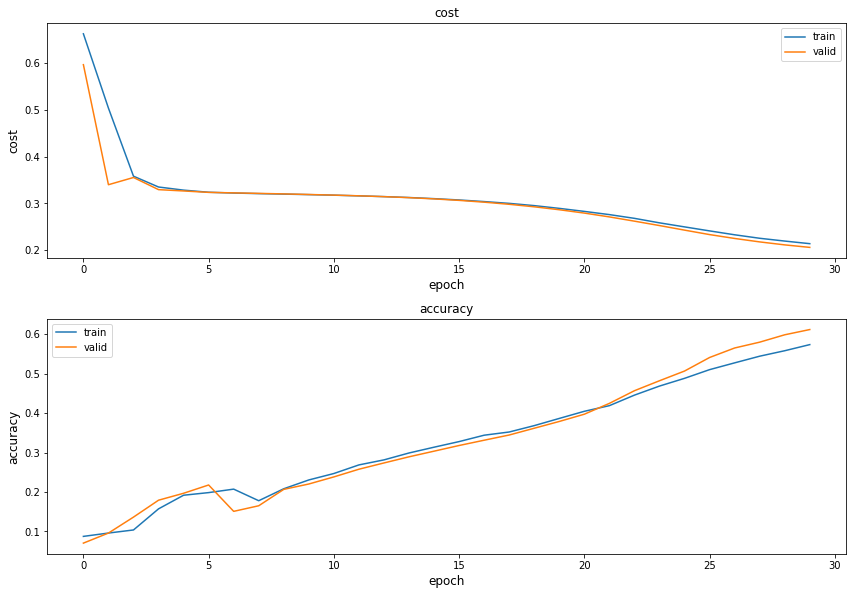

In [3]:
import matplotlib
%matplotlib inline

from core.utils import plot_jupyter
plot_jupyter(history)